In [25]:
import pandas as pd
import pandas as pd
import numpy as np
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re

In [26]:
df = pd.read_csv('/Users/com/Documents/GitHub/advanced_project/jiwon_project/csv_files/NY_Airbnb_original_df.csv')

In [27]:
# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22308 entries, 0 to 22307
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            22308 non-null  int64  
 1   source                                        22308 non-null  object 
 2   name                                          22308 non-null  object 
 3   description                                   21903 non-null  object 
 4   neighborhood_overview                         12262 non-null  object 
 5   host_id                                       22308 non-null  int64  
 6   host_name                                     22288 non-null  object 
 7   host_since                                    22288 non-null  object 
 8   host_location                                 17025 non-null  object 
 9   host_about                                    13391 non-null 

In [29]:
# booking_info
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float) 
df['instant_bookable'] =  df['instant_bookable'].map({'f':0, 't':1}) #instant_bookable = 호스트의 허락없이 에어비엔비로 거래 가능한 
df['is_long_term'] = (df['minimum_nights'] >= 28).astype(int) #오래 머무른 사람 28일 이상 기준 

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12656\965363162.py:2: SyntaxWarning: invalid escape sequence '\$'
  df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)


In [30]:
# amenities_info
def parse_amenities(x):
    try:
        return [a.strip().strip('"').strip("'") for a in ast.literal_eval(x)]
    except:
        return []
    
df['amenities'] = df['amenities'].apply(parse_amenities) #편의시설 유무 
df['amenities_cnt'] = df['amenities'].apply(len)


In [31]:
# host_info
# neighborhood_overview 결측치 많아서 유무대체 
df['neighborhood_overview_exists'] = df['neighborhood_overview'].notnull().astype(int) #동네 개요 = 동네의 특성 의미 , neighborhood_overview 사람들이 살고 교류하는 지리적으로 정의된 지역


In [32]:
# name 글자수기준 중앙값으로 그룹
df['name_length'] = df['name'].fillna('').astype(str).apply(len) 
med_length = df['name_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
    
df['name_length_group'] = df['name_length'].apply(lambda x: name_length_group(x, med_length))

In [33]:
df.isnull().sum()

id                                  0
source                              0
name                                0
description                       405
neighborhood_overview           10046
                                ...  
is_long_term                        0
amenities_cnt                       0
neighborhood_overview_exists        0
name_length                         0
name_length_group                   0
Length: 77, dtype: int64

In [34]:
# description 글자수기준(결측치 405) 평균으로 그룹
df['description_length'] = df['description'].fillna('').astype(str).apply(len) #설명문 = 소개글 
avg_length = df['description_length'].mean()

def name_length_group(length, avg):
    if length == 0:
        return 'empty'
    elif length > avg:
        return 'long'
    else:
        return 'short_or_avg'
    
df['description_length_group'] = df['description_length'].apply(lambda x: name_length_group(x, avg_length))

In [35]:
# host_about (결측치8917) 평균(243) 중앙값(81) 중앙값기준으로 그룹
df['host_about_length'] = df['host_about'].fillna('').astype(str).apply(len)
med_length = df['host_about_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
df['host_about_length_group'] = df['host_about_length'].apply(lambda x: name_length_group(x, med_length))

In [36]:
#host_identity_verified/host_has_profile_pic /host_is_superhost  
# True / Flase 1과 0으로 대체 (결측치 20/20/350 0으로 대체함)
df['host_identity_verified']=df['host_identity_verified'].fillna('f').map({'t': 1, 'f': 0}).astype(int) #호스트 신원확인

df['host_has_profile_pic']=df['host_has_profile_pic'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_is_superhost']=df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}).astype(int)


In [37]:
# host_response_time 결측치는 중앙값으로 치환후 점수
response_time_score_map = { #호스트 응답 시간
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_score'] = df['host_response_time'].map(response_time_score_map)

# 2. response_time_score 컬럼의 중앙값 계산
med_score_for_fillna = df['host_response_time_score'].median()

# 3. response_time_score 컬럼의 NaN을 계산된 중앙값으로 대체 
df['host_response_time_score'] = df['host_response_time_score'].fillna(med_score_for_fillna)

# host_response_time 칼럼에는 여전히 nan값 존재함
# response_time_score 칼럼만 중앙값대체 


In [38]:
# host_response_rate 컬럼 %제외하고 중앙값으로 대체
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate2 = df['host_response_rate'].median()
df['host_response_rate']= df['host_response_rate'].fillna(med_rate2)

# 4그룹으로 나눠 점수
conditions = [
    (df['host_response_rate'] <= 0.25),
    (df['host_response_rate'] > 0.25) & (df['host_response_rate'] <= 0.5),
    (df['host_response_rate'] > 0.5) & (df['host_response_rate'] <= 0.75),
    (df['host_response_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_response_rate_score'] = np.select(conditions, choices)


In [39]:
# host_acceptance_rate 칼럼도 %제외하고 중앙값으로 대체 
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate = df['host_acceptance_rate'].median()
df['host_acceptance_rate']= df['host_acceptance_rate'].fillna(med_rate)

conditions = [
    (df['host_acceptance_rate'] <= 0.25),
    (df['host_acceptance_rate'] > 0.25) & (df['host_acceptance_rate'] <= 0.5),
    (df['host_acceptance_rate'] > 0.5) & (df['host_acceptance_rate'] <= 0.75),
    (df['host_acceptance_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_acceptance_rate_score'] = np.select(conditions, choices)


In [40]:
# host_location 칼럼 
# host_loc 존재?
df['host_location_boolean'] = df['host_location'].notnull().astype(int)
# host_loc in NY?
df['host_location_ny'] = df['host_location'].str.contains('New York', na=False).astype(int)

In [41]:
df.head(10)

id       source                                               name  \
0  36121  city scrape                 Lg Rm in Historic Prospect Heights   
1  36647  city scrape  1 Bedroom & your own Bathroom, Elevator Apartment   
2  38663  city scrape                   Luxury Brownstone in Boerum Hill   
3  38833  city scrape                 Spectacular West Harlem Garden Apt   
4  39282  city scrape                    “Work-from-home” from OUR home.   
5  39572  city scrape                  1 br in a 2 br apt (Midtown West)   
6   6848  city scrape                   Only 2 stops to Manhattan studio   
7   6872  city scrape  Uptown Sanctuary w/ Private Bath (Month to Month)   
8   6990  city scrape                            UES Beautiful Blue Room   
9   7097  city scrape      Perfect for Your Parents, With Garden & Patio   

                                         description  \
0  Cozy space share in the heart of a great neigh...   
1  Private bedroom with your own bathroom in a 2 ...   
2  Beautiful, large home in great hipster neighbo...   
3  This is a very large and unique  space. An inc...   
4  *Monthly Discount will automatically apply <br...   
5                                                NaN   
6  Comfortable studio apartment with super comfor...   
7  This charming distancing-friendly month-to-mon...   
8                    Beautiful peaceful healthy home   
9  Parents/grandparents coming to town or are you...   

                               neighborhood_overview  host_id      host_name  \
0  Full of tree-lined streets and beautiful brown...    62165        Michael   
1   Manhattan, SE corner of 2nd Ave/ E. 110th street   157798          Irene   
2  diverse, lively, hip, cool: loaded with restau...   165789          Sarah   
3  West Harlem is now packed with great restauran...   166532        Matthew   
4  THE NEIGHBORHOOD:<br />Our apartment is locate...   168525        Gustavo   
5                                                NaN   169927         Hubert   
6                                                NaN    15991  Allen & Irina   
7  This sweet Harlem sanctuary is a 10-20 minute ...    16104      Kahshanna   
8  Location: Five minutes to Central Park, Museum...    16800            Cyn   
9  Residential, village-like atmosphere. Lots of ...    17571           Jane   

   host_since                 host_location  \
0  2009-12-11                  New York, NY   
1  2010-07-04                  New York, NY   
2  2010-07-13                  New York, NY   
3  2010-07-14                  New York, NY   
4  2010-07-16                  New York, NY   
5  2010-07-17  Saint-Aubin-sur-Scie, France   
6  2009-05-06                  New York, NY   
7  2009-05-07                  New York, NY   
8  2009-05-12                  New York, NY   
9  2009-05-17                  New York, NY   

                                          host_about  ... name_length_group  \
0  I’m an urban planner working for an internatio...  ...      short_or_med   
1                                                NaN  ...              long   
2  I am a lawyer and work as an executive at an a...  ...      short_or_med   
3  I have been a New Yorker for a long time\n and...  ...      short_or_med   
4  I am a music producer. And my wife is a hair s...  ...      short_or_med   
5  Facebook Likes:\r\nNew York French Geek, David...  ...      short_or_med   
6  We love to travel. When we travel we like to s...  ...      short_or_med   
7  A former life in fashion and wellness has left...  ...              long   
8  Capturing the Steinbeck side of life in its Fi...  ...      short_or_med   
9  I appreciate visitors and know New York well, ...  ...              long   

   description_length  description_length_group  host_about_length  \
0                 215              short_or_avg                291   
1                 117              short_or_avg                  0   
2                  84              short_or_avg                 99   
3  

In [42]:
# === rooms_info ===
# --- Personal preprocessing code ---
# Convert "beds" from float to int
# Replace missing or non-bed values with median (assumed 1)
df['beds'] = df['beds'].fillna(0).astype(int)
df['beds'] = df['beds'].replace(0, 1)

# Clean up "bathrooms", "bathrooms_text" column:
# - Replace invalid or missing values with median (assumed 1)
df['bathrooms'] = df['bathrooms'].fillna(0)

def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']
df = df.drop(columns=['bathrooms_parsed'])

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

df['is_private'] = ~df['is_shared']

In [43]:
w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

df['bathrooms'] = df['bathrooms'].replace(0.00, 1)
df['bath_score_mul'] = df['bath_score_mul'].replace(0.00, 1)

# Clean up "room_type", "property_type" column:
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

In [44]:
rt_cats = set(df['room_type'].str.strip().str.lower())
df['room_structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))

mask = df['room_structure_type'].notna()
df.loc[mask, 'room_structure_type'] = df.loc[mask, 'room_structure_type'].apply(extract_structure)
df['room_structure_type'] = df['room_structure_type'].fillna('rental unit')

In [56]:
missing_cols = [col for col in df_list if col not in df.columns]
print("존재하지 않는 컬럼:", missing_cols)



존재하지 않는 컬럼: ['structure_type']


In [54]:
for col in [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].round(2)


# list 정리
loc_cols = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude']
booking_cols = ['price', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'availability_60', 'availability_365', 'minimum_nights', 'maximum_nights', 'instant_bookable', 'is_long_term']
amenities_cols = ['amenities', 'amenities_cnt']
room_cols = ['property_type', 'room_type', 'accommodates',
        'bathrooms', 'bathrooms_text', 'beds',
        'is_shared', 'is_private', 'bath_score_mul', 'structure_type']
host_cols = ['id','host_id','name','name_length','name_length_group','description','description_length',
    'description_length_group','neighborhood_overview','neighborhood_overview_exists', 'host_about','host_about_length','host_about_length_group','host_is_superhost',
    'host_has_profile_pic','host_identity_verified','host_response_time','host_response_time_score','host_response_rate',
    'host_response_rate_score','host_acceptance_rate','host_acceptance_rate_score','host_location','host_location_ny', 'host_location_boolean'
]
reviews_cols =  ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


df_list = loc_cols + booking_cols + amenities_cols + room_cols + host_cols + reviews_cols
df = df[df_list]

# list_filtered 정리
loc_cols_filter = ['neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude']
booking_cols_filter = ['price', 'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'availability_60', 'availability_365', 'instant_bookable', 'is_long_term']
amenities_cols = ['amenities', 'amenities_cnt']
room_cols_filter = ['room_type', 'structure_type', 'accommodates', 'bath_score_mul', 'beds']
reviews_cols_filter =  ['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']
host_cols_filter = ['id','host_id','name_length_group','description_length_group','neighborhood_overview_exists','host_about_length_group','host_is_superhost',
    'host_has_profile_pic','host_identity_verified','host_response_time_score','host_response_rate_score','host_acceptance_rate_score','host_location_ny','host_location_boolean'
]

df_filter_list = loc_cols_filter + booking_cols_filter + amenities_cols + room_cols_filter + reviews_cols_filter + host_cols_filter
df_filter = df[df_filter_list]
print(df_filter)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_12656\3080528969.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


KeyError: "['structure_type'] not in index"

# 크기가 커서 그런건지 입력값이 잘못되서 그런건지 계속 디버깅만함 

In [1]:
import geopandas as gpd
import folium

# Shapefile 불러오기
gdf = gpd.read_file("/Users/com/Desktop/심화프로젝트/new data/nyc_mappluto_25v2_shp/MapPLUTO.shp")

# 좌표계가 오래된 경우 변환 (WGS84: 위도/경도 기준)
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# 지도 중심 설정 (뉴욕시 중심 대략 위경도)
map_center = [40.7128, -74.0060]
m = folium.Map(location=map_center, zoom_start=11)

# GeoJson으로 구획 추가
folium.GeoJson(
    gdf,
    name="New York MapPLUTO",
    style_function=lambda x: {
        'fillColor': '#228B22',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.4
    },
    tooltip=folium.GeoJsonTooltip(fields=['Borough', 'LandUse', 'OwnerType'], aliases=["자치구", "용도", "소유형태"])
).add_to(m)

# 지도 출력
m


KeyboardInterrupt: 

# ✅ 1단계: PLUTO Shapefile 불러오기 및 변환


In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# PLUTO shapefile 경로
pluto_fp = "/Users/com/Desktop/심화프로젝트/new data/nyc_mappluto_25v2_shp/MapPLUTO.shp"

# GeoDataFrame으로 불러오기
gdf = gpd.read_file(pluto_fp)

# 좌표계 확인 및 필요시 변환 (예: WGS84: EPSG 4326)
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs(epsg=4326)

# 데이터 확인
print(gdf.head())


  Borough  Block   Lot   CD  BCT2020    BCTCB2020 CT2010 CB2010 SchoolDist  \
0      MN      1    10  101  1000500  10005000003      5   1000         02   
1      MN      3     1  101  1031900  10319001003    319   1001         02   
2      MN      3    10  101  1031900  10319001006    319   1003         02   
3      MN      5    10  101  1000900  10009001014      9   1017         02   
4      MN      5  7501  101  1000900  10009001014      9   1017         02   

   Council  ...  FIRM07_FLA PFIRM15_FL  Version  DCPEdited   Latitude  \
0        1  ...           1          1     25v2       None  40.688774   
1        1  ...           1          1     25v2          t  40.702806   
2        1  ...           1          1     25v2       None  40.700918   
3        1  ...           1          1     25v2       None  40.702776   
4        1  ...           1          1     25v2       None  40.702266   

   Longitude Notes Shape_Leng    Shape_Area  \
0 -74.018704  None        0.0  7.414502e+06  

# ✅ 2단계: 기본 지도 시각화 (matplotlib)



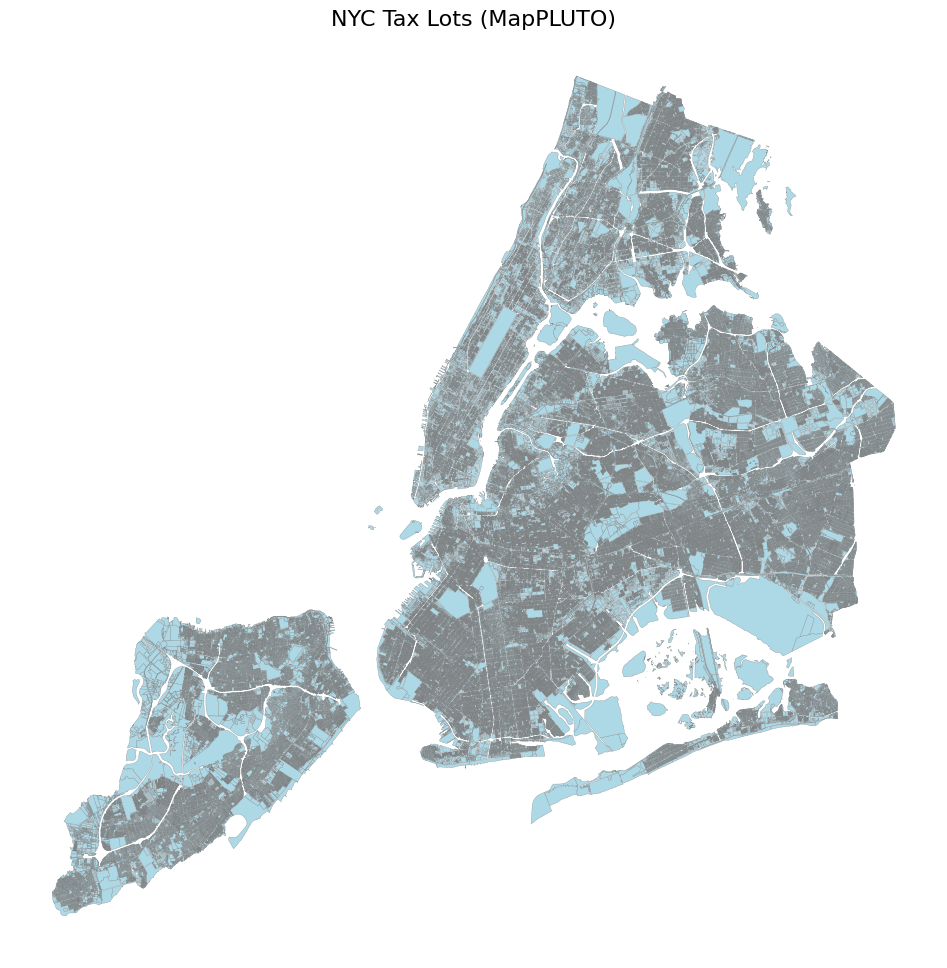

In [3]:
# 뉴욕시 택지구역 전체 시각화
fig, ax = plt.subplots(figsize=(12, 12))
gdf.plot(ax=ax, edgecolor='gray', facecolor='lightblue', linewidth=0.2)
ax.set_title("NYC Tax Lots (MapPLUTO)", fontsize=16)
plt.axis('off')
plt.show()

# ✅ 3단계: folium 지도에 시각화 (인터랙티브)


In [4]:
import folium
from folium.plugins import MarkerCluster

# 중심 좌표 설정
center = [gdf["Latitude"].mean(), gdf["Longitude"].mean()]
m = folium.Map(location=center, zoom_start=11)

# GeoJson Layer로 추가 (데이터가 너무 많다면 샘플링 권장)
sample_gdf = gdf.sample(1000)  # 너무 많으면 지도 렌더링이 느려짐

folium.GeoJson(
    sample_gdf,
    name="PLUTO Lots",
    tooltip=folium.GeoJsonTooltip(
        fields=["LandUse", "UnitsRes", "YearBuilt"],
        aliases=["Land Use", "Residential Units", "Year Built"],
        localize=True
    )
).add_to(m)

m
